Develop a machine learning (ML) algorithm capable of early detection of sepsis in pediatric patients using retrospective physiological data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from typing import Tuple, Optional, Dict, Any
from dateutil.relativedelta import relativedelta
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, classification_report
import xgboost as xgb
import lightgbm as lgb
from imblearn.over_sampling import SMOTE
from joblib import Parallel, delayed
import numpy as np

ImportError: cannot import name '_safe_tags' from 'sklearn.utils._tags' (/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/_tags.py)

In [ ]:
def calculate_age_in_months(day, birth_datetime):
    current_day = pd.to_datetime(day)
    birth_date = pd.to_datetime(birth_datetime)

    # Calculate the difference in years and months
    years_diff = current_day.year - birth_date.year
    months_diff = current_day.month - birth_date.month
    days_diff = current_day.day - birth_date.day

    # Adjust for day of month
    if days_diff < 0:
        months_diff -= 1

    return years_diff * 12 + months_diff

In [ ]:
def find_last_drug_usage(sepsis_group, drugs_group):
    """
    Find the most recent drug administration before or at each sepsis measurement.

    Args:
        sepsis_group (pd.DataFrame): DataFrame containing sepsis measurements with 'measurement_datetime'
        drugs_group (pd.DataFrame): DataFrame containing drug administrations with 'drug_datetime_hourly',
                                  'drug_concept_id', and 'route_concept_id'

    Returns:
        pd.DataFrame: Original sepsis_group with added 'last_drug_concept_id' and 'last_route_concept_id' columns
    """
    # Handle empty inputs
    if sepsis_group.empty or drugs_group.empty:
        sepsis_group['last_drug_concept_id'] = None
        sepsis_group['last_route_concept_id'] = None
        return sepsis_group

    # Convert to datetime if needed
    sepsis_group = sepsis_group.copy()
    drugs_group = drugs_group.copy()
    sepsis_group['measurement_datetime'] = pd.to_datetime(sepsis_group['measurement_datetime'])
    drugs_group['drug_datetime_hourly'] = pd.to_datetime(drugs_group['drug_datetime_hourly'])

    # Sort data
    sepsis_group = sepsis_group.sort_values('measurement_datetime')
    drugs_group = drugs_group.sort_values('drug_datetime_hourly')

    # Use merge_asof for efficient time-based merging
    result = pd.merge_asof(
        left=sepsis_group,
        right=drugs_group[['drug_datetime_hourly', 'drug_concept_id', 'route_concept_id']],
        left_on='measurement_datetime',
        right_on='drug_datetime_hourly',
        direction='backward'  # Find last drug <= measurement time
    )

    # Rename and clean up columns
    result = result.rename(columns={
        'drug_concept_id': 'last_drug_concept_id',
        'route_concept_id': 'last_route_concept_id'
    }).drop(columns=['drug_datetime_hourly'], errors='ignore')

    return result

In [ ]:
def create_dataset(
    data_type: str = "train",
    encoders: Optional[Dict] = None,
    base_path: str = "/Users/harrisonekpobimi/Desktop/sepsis hackathon prediction/",
    n_jobs: int = -1
) -> Tuple[pd.DataFrame, Optional[Dict]]:
    """
    Optimized function to create dataset for sepsis prediction with correct folder structure.
    """
    if encoders is None:
        encoders = {}

    # Set up paths
    data_dir = f"{base_path.rstrip('/')}/{data_type}ing_data/"
    is_train = (data_type == "train")

    # 1) Load and preprocess sepsis data
    sepsis_file = f"{data_dir}SepsisLabel_{data_type}.csv"
    df_sepsis = pd.read_csv(sepsis_file)
    df_sepsis = df_sepsis.drop_duplicates().sort_values(["person_id", "measurement_datetime"])
    df_sepsis['measurement_datetime'] = pd.to_datetime(df_sepsis['measurement_datetime'], errors="coerce")
    df_sepsis['day'] = df_sepsis['measurement_datetime'].dt.date.astype(str)
    df_sepsis['time_since_last_measurement'] = df_sepsis.groupby('person_id')['measurement_datetime'].diff().dt.total_seconds() / 3600
    df_sepsis['time_since_last_measurement'] = df_sepsis['time_since_last_measurement'].fillna(0)

    # Drop rows with missing person_id or measurement_datetime
    before = len(df_sepsis)
    df_sepsis = df_sepsis.dropna(subset=['person_id', 'measurement_datetime'])
    after = len(df_sepsis)
    if before != after:
        print(f"Dropped {before - after} rows from sepsis data due to missing person_id or measurement_datetime.")

    # 2) Process demographic data
    demo_file = f"{data_dir}person_demographics_episode_{data_type}.csv"
    df_demo = pd.read_csv(demo_file)
    df_demo = df_demo.sort_values('visit_start_date').drop_duplicates('person_id', keep='last')

    # Merge with sepsis data
    df = pd.merge(df_sepsis, df_demo, on='person_id', how='left')
    df['birth_datetime'] = pd.to_datetime(df['birth_datetime'], errors="coerce")

    # Drop rows with missing birth_datetime
    before = len(df)
    df = df.dropna(subset=['birth_datetime'])
    after = len(df)
    if before != after:
        print(f"Dropped {before - after} rows after merge due to missing birth_datetime.")

    def safe_month_diff(row):
        if pd.isna(row['measurement_datetime']) or pd.isna(row['birth_datetime']):
            return np.nan
        return (row['measurement_datetime'].to_period('M') - row['birth_datetime'].to_period('M')).n

    df['age_in_months'] = df.apply(safe_month_diff, axis=1)
    df = df.drop(columns=['visit_occurrence_id', 'visit_start_date', 'birth_datetime'], errors='ignore')

    # 3) Process drug data
    def process_drugs(person_id, grp, df_drugs):
        grp_drugs = df_drugs[df_drugs["person_id"] == person_id]
        return find_last_drug_usage(grp, grp_drugs)

    try:
        df_drugs = pd.read_csv(f"{data_dir}drugsexposure_{data_type}.csv")
        df_drugs['drug_datetime_hourly'] = pd.to_datetime(df_drugs['drug_datetime_hourly'], errors="coerce")

        # Process in parallel
        groups = [(pid, grp) for pid, grp in df.groupby('person_id')]
        results = Parallel(n_jobs=n_jobs)(
            delayed(process_drugs)(pid, grp, df_drugs)
            for pid, grp in groups
        )
        df = pd.concat(results, ignore_index=True)
    except FileNotFoundError:
        print(f"Drug data not found at {data_dir}drugsexposure_{data_type}.csv")

    # 4) Process observation data
    try:
        obs_file = f"{data_dir}measurement_meds_{data_type}.csv"
        df_obs = pd.read_csv(obs_file)
        df_obs['day'] = pd.to_datetime(df_obs['measurement_datetime'], errors="coerce").dt.date.astype(str)

        # Filter outliers
        if 'Heart rate' in df_obs.columns and 'Respiratory rate' in df_obs.columns:
            df_obs = df_obs[df_obs["Heart rate"].between(0, 200) &
                          df_obs["Respiratory rate"].between(0, 40)]

            # Aggregate by day
            obs_agg = df_obs.groupby(["person_id", "day"]).agg({
                "Body temperature": "max",
                "Respiratory rate": "max",
                "Heart rate": "max",
                "Measurement of oxygen saturation at periphery": "mean"
            }).reset_index()

            df = df.merge(obs_agg, on=["person_id", "day"], how="left")
    except FileNotFoundError:
        print(f"Observation data not found at {data_dir}measurement_meds_{data_type}.csv")

    # 5) Process lab data
    try:
        lab_file = f"{data_dir}measurement_lab_{data_type}.csv"
        df_lab = pd.read_csv(lab_file)
        df_lab.columns = df_lab.columns.str.replace(r'[\[\]]', '', regex=True)
        df_lab['day'] = pd.to_datetime(df_lab['measurement_datetime'], errors="coerce").dt.date.astype(str)

        # Get numeric columns and aggregate
        numeric_cols = df_lab.select_dtypes(include=np.number).columns.tolist()
        if 'person_id' in numeric_cols:
            numeric_cols.remove('person_id')
        if 'visit_occurrence_id' in numeric_cols:
            numeric_cols.remove('visit_occurrence_id')

        if numeric_cols:
            lab_agg = df_lab.groupby(['person_id', 'day'])[numeric_cols].mean().reset_index()
            df = df.merge(lab_agg, on=['person_id', 'day'], how='left')
    except FileNotFoundError:
        print(f"Lab data not found at {data_dir}measurement_lab_{data_type}.csv")

    # 6) Handle missing values
    numeric_cols = df.select_dtypes(include=np.number).columns
    if not numeric_cols.empty:
        df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

    # 7) Encode categorical variables
    cat_cols = ["gender", "current_drug_concept_id", "current_route_concept_id",
                "last_drug_concept_id", "last_route_concept_id"]

    for col in cat_cols:
        if col in df.columns:
            df[col] = df[col].astype(str)
            if is_train:
                le = LabelEncoder()
                df[col] = le.fit_transform(df[col])
                encoders[col] = le
            else:
                le = encoders.get(col)
                if le is not None:
                    mask = df[col].isin(le.classes_)
                    if not mask.all():
                        df.loc[~mask, col] = le.classes_[0]
                    df[col] = le.transform(df[col])

    # 8) Final cleanup
    cols_to_drop = ['day', 'visit_occurrence_id', 'visit_occurence_id',
                   'Ionised calcium measurement', 'Unnamed: 0']
    df = df.drop(columns=[c for c in cols_to_drop if c in df.columns], errors='ignore')

    return df, encoders


In [ ]:
encoders = {}  # Store label encoders here

# Create the TRAIN dataset
try:
    df_train, encoders = create_dataset("train", encoders=encoders)
    print(f"Train dataset shape: {df_train.shape}")
except Exception as e:
    print(f"Error creating train dataset: {e}")
    df_train = None

# Create the TEST dataset
try:
    df_test, _ = create_dataset("test", encoders=encoders)
    print(f"Test dataset shape: {df_test.shape}")
except Exception as e:
    print(f"Error creating test dataset: {e}")
    df_test = None

# Check for missing merge keys in train and test
def check_merge_keys(df, name):
    if df is not None:
        missing_person = df['person_id'].isna().sum() if 'person_id' in df.columns else 'N/A'
        missing_day = df['day'].isna().sum() if 'day' in df.columns else 'N/A'
        print(f"{name}: missing person_id: {missing_person}, missing day: {missing_day}")

check_merge_keys(df_train, 'Train')
check_merge_keys(df_test, 'Test')

Dropped 15 rows from sepsis data due to missing person_id or measurement_datetime.
Train dataset shape: (331624, 48)
Test dataset shape: (130483, 47)
Train: missing person_id: 0, missing day: N/A
Test: missing person_id: 0, missing day: N/A


In [ ]:
df_train.head()

,person_id,measurement_datetime,SepsisLabel,time_since_last_measurement,age_in_months,gender,last_drug_concept_id,last_route_concept_id,Body temperature,Respiratory rate,...,Bilirubin measurement,Partial thromboplastin time,activated,Total white blood count,Platelet count,White blood cell count,Blood venous pH,D-dimer level,Blood arterial pH,Hemoglobin Moles/volume in Blood
0,510305,2019-07-01 16:00:00,0,0.0,26,0,39,10,36.8,35.929688,...,5.1,30.6,4.0,44.0,0.6,7.42,3.69,7.38,8.6,1.25
1,510305,2019-07-01 17:00:00,0,1.0,26,0,39,10,36.8,35.929688,...,5.1,30.6,4.0,44.0,0.6,7.42,3.69,7.38,8.6,1.25
2,510305,2019-07-02 13:00:00,0,20.0,26,0,34,2,36.8,35.929688,...,5.1,30.6,9.5,197.0,0.1,7.38,3.69,7.38,10.5,1.25
3,510305,2019-07-03 09:00:00,0,20.0,26,0,34,2,36.8,35.929688,...,5.1,31.9,4.3,41.0,0.0,7.38,3.69,7.38,8.9,1.25
4,510305,2019-07-03 10:00:00,0,1.0,26,0,34,2,36.8,35.929688,...,5.1,31.9,4.3,41.0,0.0,7.38,3.69,7.38,8.9,1.25


In [ ]:
counts = df_train["SepsisLabel"].value_counts()
print(counts)

SepsisLabel
0    324750
1      6874
Name: count, dtype: int64


In [ ]:
# Features and target
X = df_train.drop(["person_id", "SepsisLabel", "measurement_datetime"], axis=1)  # Features
y = df_train["SepsisLabel"]  # Binary target
groups = df_train["person_id"]  # Groups to ensure the same person doesn't appear in both train and validation sets

# Use GroupShuffleSplit to avoid having the same person_id in both train and validation sets
from sklearn.model_selection import GroupShuffleSplit
gss = GroupShuffleSplit(test_size=0.2, random_state=42)  # 20% of data for validation
train_idx, val_idx = next(gss.split(X, y, groups))

# Split the data
X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

# Apply SMOTE to the training set to oversample the minority class
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=5)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Convert resampled data to DataFrame and Series
X_train_resampled = pd.DataFrame(X_train_resampled, columns=X_train.columns)
y_train_resampled = pd.Series(y_train_resampled)

In [ ]:
# Instantiate the model
xgb_model = xgb.XGBClassifier(
    n_estimators=200,       # Maximum number of trees
    learning_rate=0.05,     # Learning rate
    max_depth=8,            # Tree depth
    subsample=0.8,          # Row subsampling
    colsample_bytree=0.8,   # Feature subsampling
    random_state=42,
    reg_alpha=0.1,          # L1 regularization
    reg_lambda=1.0          # L2 regularization
)

# Train the model with early stopping
xgb_model.fit(
    X_train_resampled, y_train_resampled,
    eval_set=[(X_val, y_val)],
    # eval_metric="auc",             # Uncomment to compute AUC at each iteration
    # early_stopping_rounds=10,      # Uncomment to enable early stopping
    verbose=True
)

[0]	validation_0-logloss:0.65974
[1]	validation_0-logloss:0.62954
[2]	validation_0-logloss:0.60121
[3]	validation_0-logloss:0.57618
[4]	validation_0-logloss:0.55313
[5]	validation_0-logloss:0.53113
[6]	validation_0-logloss:0.51013
[7]	validation_0-logloss:0.49161
[8]	validation_0-logloss:0.47485
[9]	validation_0-logloss:0.45952
[10]	validation_0-logloss:0.44527
[11]	validation_0-logloss:0.43182
[12]	validation_0-logloss:0.41905
[13]	validation_0-logloss:0.40432
[14]	validation_0-logloss:0.39274
[15]	validation_0-logloss:0.38120
[16]	validation_0-logloss:0.37099
[17]	validation_0-logloss:0.36011
[18]	validation_0-logloss:0.35123
[19]	validation_0-logloss:0.34116
[20]	validation_0-logloss:0.33318
[21]	validation_0-logloss:0.32590
[22]	validation_0-logloss:0.31903
[23]	validation_0-logloss:0.31267
[24]	validation_0-logloss:0.30478
[25]	validation_0-logloss:0.29865
[26]	validation_0-logloss:0.29268
[27]	validation_0-logloss:0.28741
[28]	validation_0-logloss:0.28139
[29]	validation_0-loglos

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [ ]:
# Predict probabilities for class 1
y_pred_proba = xgb_model.predict_proba(X_val)[:, 1]

# Calculate AUC
auc_val = roc_auc_score(y_val, y_pred_proba)
print("Validation AUC:", auc_val)

AUC sur l'ensemble de validation : 0.93444780472119


In [ ]:
# Predict class labels
y_pred_class = xgb_model.predict(X_val)

# Calculate accuracy
acc_val = accuracy_score(y_val, y_pred_class)
print("Accuracy:", acc_val)

# Calculate F1 scores for each class
f1_val_per_class = f1_score(y_val, y_pred_class, average=None)

# Display F1 scores for each class
for label, f1 in enumerate(f1_val_per_class):
    print(f"F1 Score for class {label}:", f1)

# Display detailed classification report
print("\nClassification Report:")
print(classification_report(y_val, y_pred_class))

Accuracy : 0.9669755845133368
F1 Score for class 0: 0.9831263520551238
F1 Score for class 1: 0.22913616398243045

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     62463
           1       0.22      0.24      0.23      1308

    accuracy                           0.97     63771
   macro avg       0.60      0.61      0.61     63771
weighted avg       0.97      0.97      0.97     63771



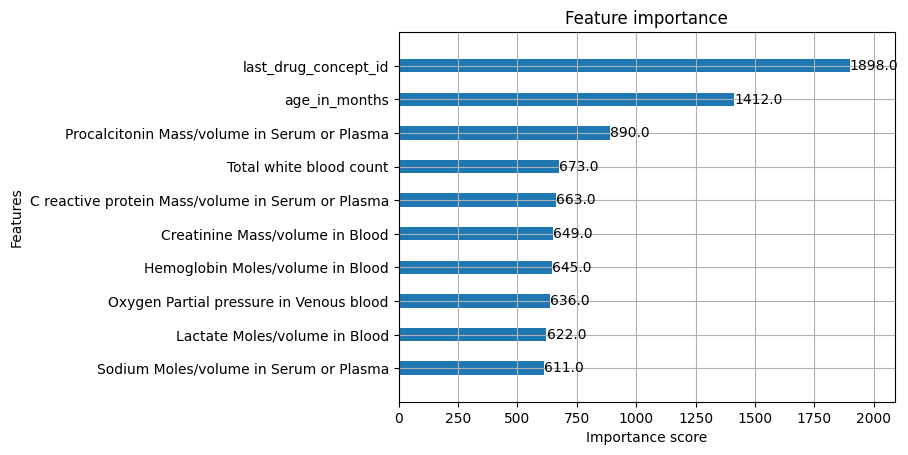

In [ ]:
xgb.plot_importance(xgb_model, max_num_features=10, height=0.4)
plt.show()